title: Brasard-Høyer-Tapp Algorithm in Qiskit
<!--eofm-->

A Womanium Global Media Project Initiative

[Previously](https://gopal-dahale.github.io/ILearnQuantum/posts/bht/quantum_collision_finding/), we discussed the theoritical aspects of Quantum Collision Finding and the BHT algorithm. We now try to implement in the BHT algorithm using Qiskit for small functions. We'll create a class for this and explain it step-by-step. First let's import essential packages.

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.tools.visualization import plot_histogram, plot_distribution
from qiskit.algorithms.algorithm_result import AlgorithmResult
from qiskit.providers.ibmq import IBMQ
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import Statevector

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
from qiskit_ibm_runtime import Sampler as RuntimeSampler

from qiskit_aer.noise import NoiseModel
from qiskit.algorithms.algorithm_result import AlgorithmResult

seed = 42
np.random.seed(seed)

/tmp/ipykernel_19732/1860068868.py:5: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.algorithm_result import AlgorithmResult


## Implementation

The `BHT` class below implements the BHT algorithm. The class takes a Qiskit Sampler object `sampler`, the n-bit hash function `fn` and the input size `n`. Most of the algorithm is present in the `solve` function of the class.

In [2]:
class BHT:

    def __init__(self, sampler, fn, n):
        """
        Initialize the BHT algorithm class
        
        Args:
            sampler (Sampler): Qiskit's Sampler Object
            fn (np.ndarray): Function whose collisions we want to find 
            represented by a numpy array.
            n (int): Maximum length of a input/output
        """

        self.n = n
        self.fn = fn
        self.N = 2**n  # Total number of inputs (Domain)
        self.sampler = sampler

    def _search(self, x, F_x):
        """
        Check whether there exists x_0 ∈ K so that (x_0, F(x)) ∈ L but x  != x_0.
        Since L is sorted by hashes we use binary search on L.  

        Args:
            x (int): Input x
            y (int): Value of the function evaluated at x
        Returns:
            index (int): Returns the index of x_0 if found, else -1
        """
        low = 0
        high = self.k - 1
        while low <= high:
            mid = (low + high) // 2
            x0 = self.L[mid][0]
            if (F_x == self.L[mid][1]) and (x != x0):
                return x0
            elif self.L[mid][1] < F_x:
                low = mid + 1
            else:
                high = mid - 1
        return -1

    def _H_mat(self):
        """ 
        Creates a unitary matrix for H: X -> {0, 1}
        
        Returns:
            qc (Gate): Gate representing the H matrix
        """

        size = 2**self.n  # Since |X| = n, we need n+1 qubits
        U = np.zeros((size, size))  # Initialize the matrix

        for x in range(size):
            y = self.fn[x]  # Compute the function of x
            x0 = self._search(x, y)

            if x0 == -1:
                U[x][x] = 1
            else:
                U[x][x] = -1  # Phase flip if such x0 exists

        qc = QuantumCircuit(self.n)
        qc.unitary(U, range(self.n))
        oracle = qc.to_gate()
        oracle.name = 'U$_\omega$'
        return oracle

    def _diffuser(self, nqubits):
        """
        Diffuser for Grover's algorithm

        Returns:
            U_s (Gate): Diffuser circuit.
        """
        qc = QuantumCircuit(nqubits)
        for qubit in range(nqubits):
            qc.h(qubit)
        for qubit in range(nqubits):
            qc.x(qubit)
        qc.h(nqubits - 1)
        qc.mct(list(range(nqubits - 1)),
               nqubits - 1)  # multi-controlled-toffoli
        qc.h(nqubits - 1)
        for qubit in range(nqubits):
            qc.x(qubit)
        for qubit in range(nqubits):
            qc.h(qubit)
        U_s = qc.to_gate()
        U_s.name = "U$_s$"
        return U_s

    def construct_circuit(self):
        """
        Construction of the Grover's circuit.

        Returns:
            qc (QuantumCircuit): Grover's circuit.
        """

        qc = QuantumCircuit(self.n, self.n)
        qc.h(range(self.n))
        qc.barrier()
        
        self.svs = [Statevector.from_label('0'*self.n).evolve(qc)]

        oracle = self._H_mat()  # Oracle H of Grover(H,1)
        self.num_iterations = int(np.sqrt(self.N / self.k))

        for i in range(self.num_iterations):
            qc.append(oracle, range(self.n))
            self.svs += [Statevector.from_label('0'*self.n).evolve(qc)]
            qc.append(self._diffuser(self.n), range(self.n))
            self.svs += [Statevector.from_label('0'*self.n).evolve(qc)]
            qc.barrier()

        qc.measure(range(self.n), range(self.n))

        return qc

    def find_collisions(self, x):
        """
        Finds collisions from the result of Grover's circuit execution.

        Returns:
            collisions (List[tuple]): A list of three element tuple (a, b, c) 
            such that fn[a] = f[b] = c.
        """

        collisions = []

        for i in x:
            y = self.fn[i]
            x0 = self._search(i, y)
            if x0 != -1:
                collisions.append((x0, i, y))
        return collisions

    def solve(self):
        """
        Performs the BHT algorithm.

        Returns:
            collisions (List[tuple]): A list of three element tuple (a, b, c) 
            such that fn[a] = f[b] = c.
        """

        X = range(self.N)  # Domain of function

        # Step 1.1:

        # Start by selecting an arbitrary subset K ⊆ X of cardinality k = 2^(n/3).
        self.k = int(np.ceil(np.cbrt(self.N)))
        K = np.random.choice(X, self.k, replace=False)

        # Create a table L where each item in L holds a unique pair
        # (x, F(x)) with x ∈ K
        self.L = [(i, self.fn[i]) for i in K]

        # Step 1.2: Sort L according to the second entry in each item of L.
        self.L.sort(key=lambda x: x[1])

        # Step 1.3:

        # Verify whether L contains any collisions, meaning check if there
        # are distinct elements (x_0, F(x_0)), (x_1, F(x_1)) ∈ L
        # such that F(x_0) = F(x_1).

        collisions = []
        result = AlgorithmResult()

        flag = False
        for i in range(1, self.k):
            if self.L[i - 1][1] == self.L[i][1]:  # Hashes are equal
                print("Collision Found")
                collisions.append(
                    (self.L[i - 1][0], self.L[i][0], self.L[i][1]))
                flag = True
                break

        if flag == True:
            # If so, proceed to Step 2.3:
            # Output the collision set {x_0, x_1}.

            result.collisions = collisions
            result.classical = True
            return result

        # If not, the 2^(n/3) pairs of L are stored in qRAM.

        # Construct the circuit for the Grover's algorithm
        qc = self.construct_circuit()

        # Step 2.1: Calculate x1 =  Grover(H, 1)
        # Note that since multiple collisions exists
        # x1 denotes one such solution
        # but after executing the circuit we can get
        # more than one x1.
        job = self.sampler.run(qc)
        res = job.result()
        quasi_dist = res.quasi_dists[0]
        probs = quasi_dist.binary_probabilities()
        probs = dict(sorted(probs.items(), reverse=True, key=lambda i: i[1]))

        prob_keys = list(probs.keys())
        x = [int(i, 2) for i in prob_keys]

        # Step 2.2: Search (x0, F(x1)) ∈ L
        collisions = self.find_collisions(x)

        # Step 2.3: Output the collision set {x_0, x_1}
        result.iterations = self.num_iterations
        result.probs = probs
        result.circuit = qc
        result.collisions = collisions
        result.classical = False

        return result

We also define a `solve_classical` function which classically compute the collisions for the given function `fn`.

In [3]:
def solve_classical(fn):
    """
    Classically computes the collisions in the function `fn`. 

    Args:
        fn (np.ndarray): Function whose collisions we want to find represented 
        by a numpy array.
    Returns:
        collisions (List[tuple]): A list of three element tuple (a, b, c) 
        such that fn[a] = f[b] = c.
    """

    unique_elements, inverse, counts = np.unique(fn,
                                                 return_inverse=True,
                                                 return_counts=True)
    duplicate_indices = np.where(counts > 1)[0]
    collisions = []

    for idx in duplicate_indices:
        indices = np.where(inverse == idx)[0]
        for i, j in zip(indices[:-1], indices[1:]):
            collisions.append((i, j, unique_elements[idx]))

    return collisions

## Ideal Simulation

We now test the BHT algorithm with a 5-bit function i.e. `n = 5`.

In [4]:
n = 5  # Maximum length of a input/output
N = 2**n  # Total number of inputs (Domain)
X = range(N)  # Domain of hash function

# Function
func = np.array([np.random.randint(low=0, high=N) for i in X])
func

array([ 6, 19, 28, 14, 10,  7, 28, 20,  6, 25, 18, 22, 10, 10, 23, 20,  3,
        7, 23,  2, 21, 20,  1, 23, 11, 29,  5,  1, 31, 27, 20,  0])

First we try to find the collisions classically.

In [5]:
collisions = solve_classical(func)
collisions

[(22, 27, 1),
 (0, 8, 6),
 (5, 17, 7),
 (4, 12, 10),
 (12, 13, 10),
 (7, 15, 20),
 (15, 21, 20),
 (21, 30, 20),
 (14, 18, 23),
 (18, 23, 23),
 (2, 6, 28)]

Now we use the BHT algorithm to find collisions in the function. 

In [6]:
np.random.seed(seed)

sampler = Sampler()
bht = BHT(sampler, func, n)
result = bht.solve()  # Find collisions

print(result)

{   'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fc22db0b3a0>,
    'classical': False,
    'collisions': [(17, 5, 7), (15, 21, 20), (15, 7, 20), (15, 30, 20)],
    'iterations': 2,
    'probs': {   '00000': 0.001953125,
                 '00001': 0.001953125,
                 '00010': 0.001953125,
                 '00011': 0.001953125,
                 '00100': 0.001953125,
                 '00101': 0.2363281249999989,
                 '00110': 0.001953125,
                 '00111': 0.2363281249999988,
                 '01000': 0.001953125,
                 '01001': 0.001953125,
                 '01010': 0.001953125,
                 '01011': 0.001953125,
                 '01100': 0.001953125,
                 '01101': 0.001953125,
                 '01110': 0.001953125,
                 '01111': 0.001953125,
                 '10000': 0.001953125,
                 '10001': 0.001953125,
                 '10010': 0.001953125,
                 '10011': 0.001953125,


We can see that the algorithm halted successfully and below is the quantum circuit used for finding the collisions. We can see that it uses 2 iterations of the Grover's algorithm.

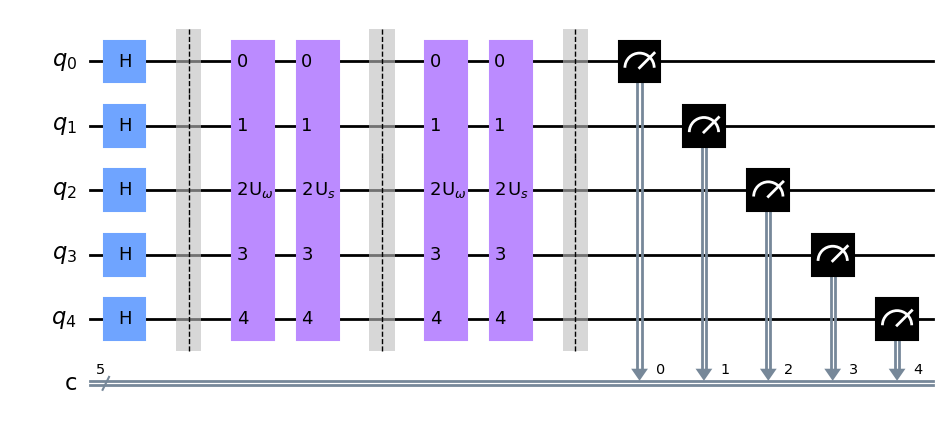

In [7]:
result.circuit.draw('mpl')

From the histogram, we can see that there are 4 collisions. 

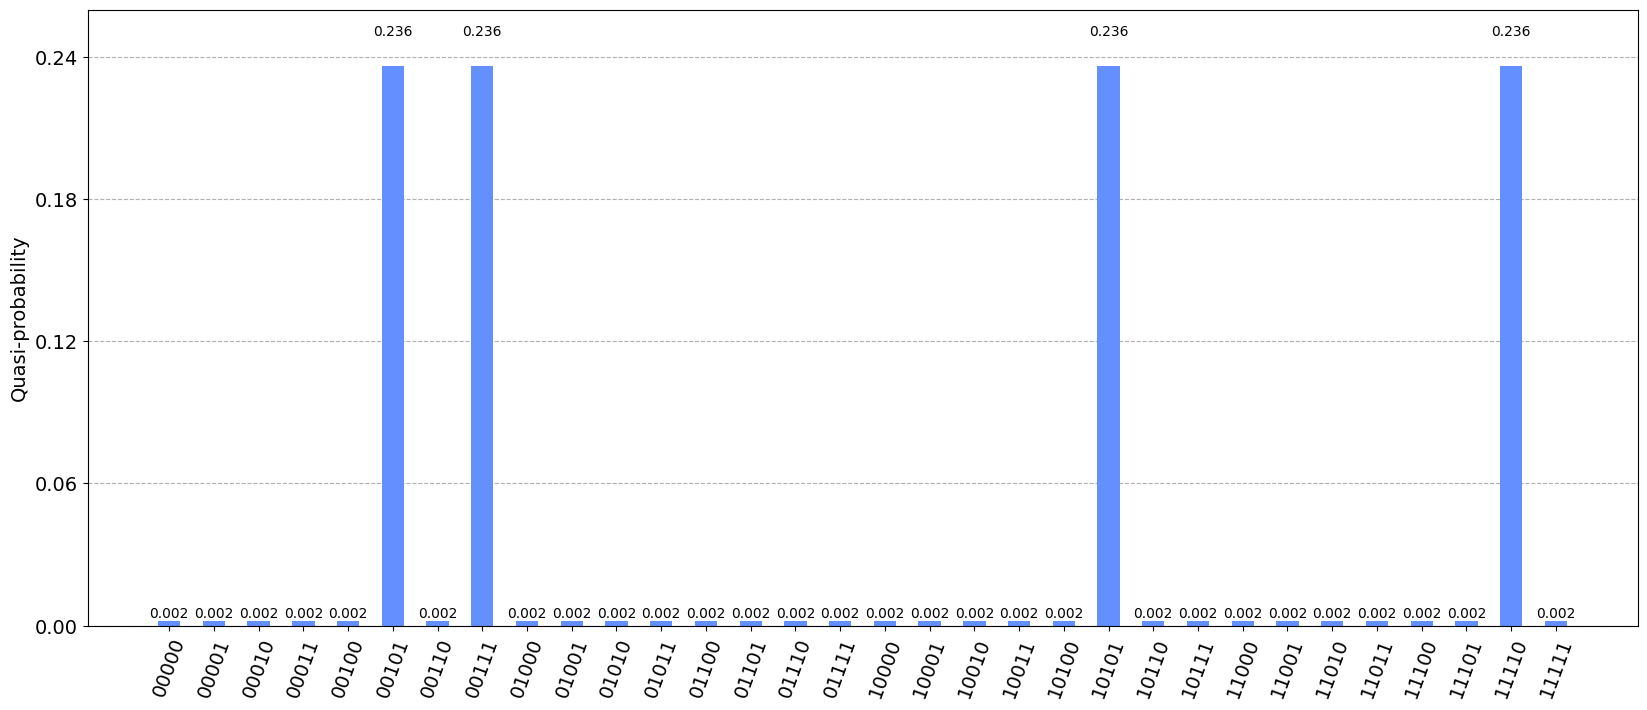

In [8]:
plot_histogram(result.probs, figsize=(20, 8))

In [9]:
result.collisions

[(17, 5, 7), (15, 21, 20), (15, 7, 20), (15, 30, 20)]

In [10]:
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_state_paulivec
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

sns.set_style('whitegrid')

In [11]:
bin_keys = list(map(lambda x: bin(x)[2:].zfill(n), np.arange(0, 2**n)))

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

0
0
1
2
3
4
0


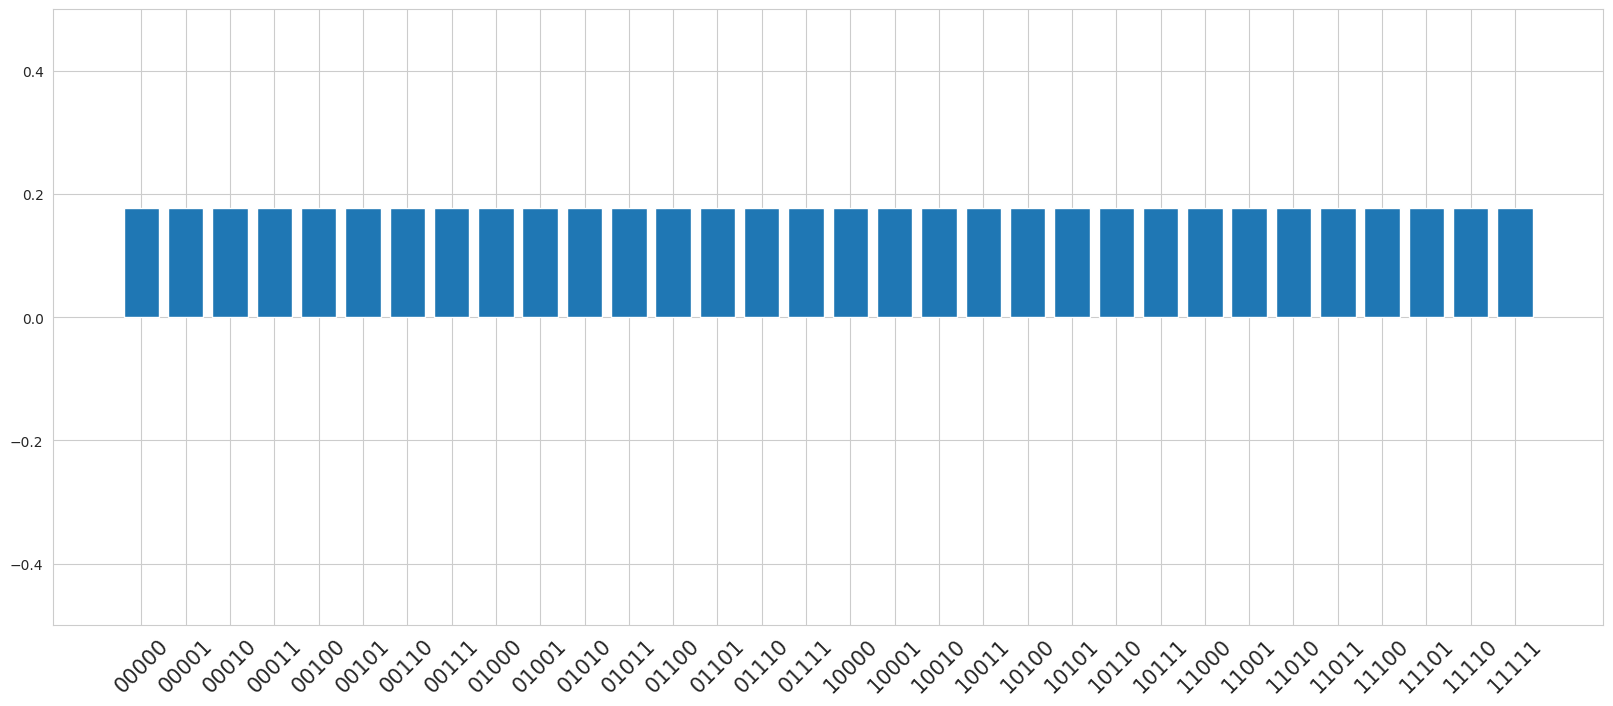

In [14]:
import matplotlib.pyplot as plt
from matplotlib import animation


def barlist(i):
    return bht.svs[i].data.real


fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

x = np.arange(0, 2**n)
barcollection = ax.bar(x, barlist(1))
ax.xaxis.set_ticks(x)
ax.xaxis.set_ticklabels(bin_keys, rotation=45, fontsize=15)
ax.set_ylim(-0.5, 0.5)

def animate(i):
    print(i)
    y = barlist(i)
    
    for i, b in enumerate(barcollection):
        b.set_height(y[i])


anim = animation.FuncAnimation(fig,
                               animate,
                               repeat=False,
                               blit=False,
                               frames=len(bht.svs),
                               interval=20)
anim.save('./animation.gif', writer='imagemagick', fps=1)

Hurray! We can observe that the collisions found by the BHT algorithm are also present in the classical solutions.